# Matplotlib a Vega-Lite: Mejora en el Manejo de Histogramas

Este notebook demuestra una mejor forma de extraer datos de un histograma de Matplotlib y convertirlos a una visualización Vega-Lite con Altair.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import altair as alt
import json
from pprint import pprint

# Función para detectar el tipo de gráfico en un objeto Axes de Matplotlib
def detect_plot_type(ax):
    """
    Detecta el tipo de gráfico en un objeto Axes de Matplotlib.
    Retorna una cadena con el tipo de gráfico detectado.
    """
    # Verificar en los contenedores si hay algún histograma
    if hasattr(ax, 'containers') and ax.containers:
        for container in ax.containers:
            if type(container).__name__ == 'BarContainer':
                # Si el contenedor tiene "hist" en la etiqueta o si es un contenedor de barras
                # y las barras tienen anchos similares, es probable que sea un histograma
                if hasattr(container, 'get_label') and 'hist' in container.get_label().lower():
                    return 'histogram'
    
    # Verificar si el método hist se ha llamado (resultado almacenado como _hold_hist)
    for key in dir(ax):
        if key.startswith('_') and 'hist' in key.lower():
            return 'histogram'
    
    # Verificar gráficos de dispersión (PathCollection)
    if hasattr(ax, 'collections') and ax.collections:
        for collection in ax.collections:
            if type(collection).__name__ == 'PathCollection':
                return 'scatter'
    
    # Verificar gráficos de líneas (Line2D)
    if hasattr(ax, 'lines') and ax.lines:
        return 'line'
    
    # Verificar gráficos de barras y histogramas (Rectangle patches)
    if hasattr(ax, 'patches') and ax.patches:
        if all(type(patch).__name__ == 'Rectangle' for patch in ax.patches):
            # Diferenciar entre histogramas y gráficos de barras
            # Los histogramas suelen tener barras de igual anchura y muchos más elementos
            patch_widths = [patch.get_width() for patch in ax.patches]
            
            # Criterios para identificar un histograma:
            # 1. Muchas barras (> 5)
            # 2. Ancho de barras consistente (pocos valores únicos)
            # 3. Barras adyacentes sin espacios
            
            if len(patch_widths) > 5:
                unique_widths = len(set(round(w, 5) for w in patch_widths))
                
                # Si la mayoría de los anchos son iguales (con una pequeña tolerancia)
                if unique_widths <= 3:
                    # Verificar si las barras son adyacentes (criterio adicional para histogramas)
                    x_positions = sorted([patch.get_x() for patch in ax.patches])
                    adjacent = all(
                        abs((x_positions[i+1] - (x_positions[i] + patch_widths[i]))) < 1e-5
                        for i in range(len(x_positions)-1)
                    )
                    
                    if adjacent:
                        return 'histogram'
            
            # Si no cumple criterios de histograma, es un gráfico de barras
            return 'bar'
    
    # Si no se puede determinar, devolver desconocido
    return 'unknown'

# Función mejorada para extraer datos de un histograma
def extract_histogram_data(ax):
    """
    Extrae los datos de un histograma de Matplotlib de forma más robusta.
    """
    data = {}
    
    # Método 1: Intentar obtener los datos directamente de la salida de hist
    # La función hist() devuelve (n, bins, patches)
    hist_data = None
    
    # Buscar si tenemos acceso a la tupla de retorno de hist()
    for key in dir(ax):
        if key.startswith('_') and 'hist' in key.lower():
            hist_data = getattr(ax, key, None)
            if hist_data and isinstance(hist_data, tuple) and len(hist_data) >= 2:
                # Encontramos los datos del histograma
                hist_counts = hist_data[0]
                hist_bins = hist_data[1]
                print(f"Datos del histograma encontrados en '{key}': {len(hist_counts)} bins")
                
                # Calcular centros de los bins
                bin_centers = [(hist_bins[i] + hist_bins[i+1]) / 2 for i in range(len(hist_bins)-1)]
                
                # Crear datos para DataFrame
                data['bin_start'] = hist_bins[:-1]
                data['bin_end'] = hist_bins[1:]
                data['bin_width'] = [hist_bins[i+1] - hist_bins[i] for i in range(len(hist_bins)-1)]
                data['x'] = bin_centers
                data['y'] = hist_counts
                data['count'] = hist_counts
                data['density'] = hist_counts / sum(hist_counts) if sum(hist_counts) > 0 else hist_counts
                data['label'] = ['histogram'] * len(hist_counts)
                return data
    
    # Método 2: Si no encontramos los datos directamente, extraerlos de los patches
    if not data:
        print("Extrayendo datos de histograma a partir de los patches...")
        if hasattr(ax, 'patches') and ax.patches:
            edges = []  # Almacena los bordes de los bins
            heights = []  # Almacena las alturas
            
            # Ordenar los parches por posición x para asegurarnos de que están en orden
            patches = sorted(ax.patches, key=lambda p: p.get_x())
            
            for patch in patches:
                x = patch.get_x()
                width = patch.get_width()
                height = patch.get_height()
                
                # Guardar el borde izquierdo y la altura
                edges.append(x)
                heights.append(height)
                
                # Para el último bin, también necesitamos el borde derecho
                if len(edges) == len(patches):
                    edges.append(x + width)
            
            # Crear valores x para representar el centro de cada bin
            bin_centers = [(edges[i] + edges[i+1])/2 for i in range(len(edges)-1)]
            
            # Guardar datos
            data['bin_start'] = edges[:-1]
            data['bin_end'] = edges[1:]
            data['bin_width'] = [edges[i+1] - edges[i] for i in range(len(edges)-1)]
            data['x'] = bin_centers
            data['y'] = heights
            data['count'] = heights
            data['density'] = [h / sum(heights) if sum(heights) > 0 else h for h in heights]
            data['label'] = ['histogram'] * len(heights)
    
    return data

# Función para crear una mejor visualización de histograma con Vega-Lite
def create_vega_lite_histogram(ax, data):
    """
    Crea una visualización de histograma en Vega-Lite a partir de los datos extraídos.
    """
    df = pd.DataFrame(data)
    
    # Crear un gráfico de barras que represente el histograma
    chart = alt.Chart(df).mark_bar(
        tooltip=True,
        opacity=0.7,
        stroke='black',
        strokeWidth=0.5
    ).encode(
        x=alt.X('x:Q', 
                title=ax.get_xlabel() or 'Valores',
                scale=alt.Scale(domain=[df['bin_start'].min(), df['bin_end'].max()]),
                axis=alt.Axis(tickCount=min(20, len(df)))),
        y=alt.Y('y:Q', 
                title=ax.get_ylabel() or 'Frecuencia'),
        tooltip=[
            alt.Tooltip('bin_start', title='Inicio', format='.2f'),
            alt.Tooltip('bin_end', title='Fin', format='.2f'),
            alt.Tooltip('count', title='Frecuencia')
        ]
    ).properties(
        title=ax.get_title() or 'Histograma',
        width=600,
        height=400
    )
    
    return chart

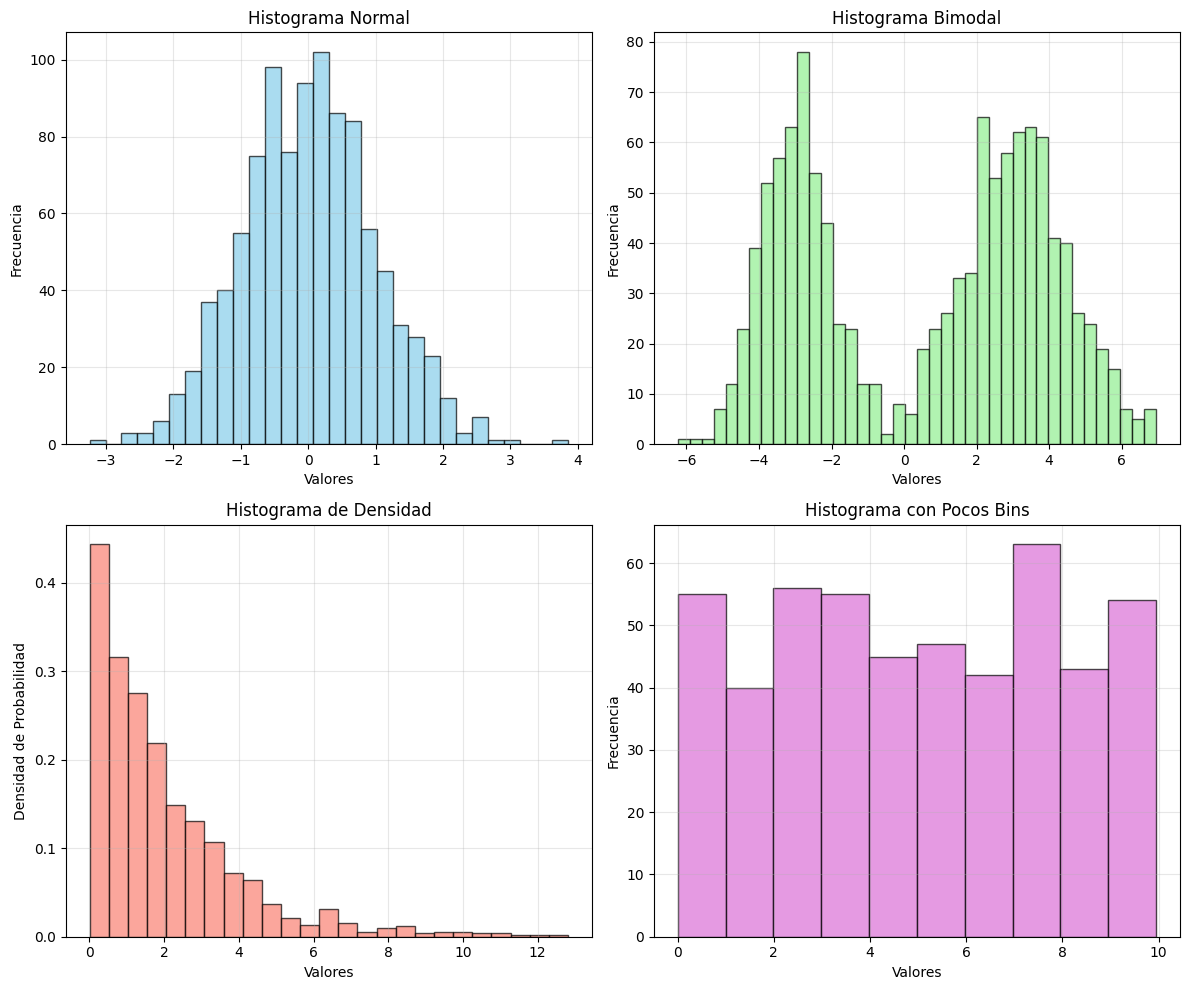

In [2]:
# Crear varios ejemplos de histogramas con diferentes características

# 1. Histograma con distribución normal
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
np.random.seed(42)
data_normal = np.random.normal(0, 1, 1000)
hist1 = plt.hist(data_normal, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Histograma Normal')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
ax1 = plt.gca()  # Obtener el axes actual

# 2. Histograma con distribución bimodal
plt.subplot(2, 2, 2)
np.random.seed(42)
data1 = np.random.normal(-3, 1, 500)
data2 = np.random.normal(3, 1.5, 700)
bimodal_data = np.concatenate([data1, data2])
hist2 = plt.hist(bimodal_data, bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Histograma Bimodal')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
ax2 = plt.gca()  # Obtener el axes actual

# 3. Histograma con opciones de densidad
plt.subplot(2, 2, 3)
exp_data = np.random.exponential(scale=2.0, size=1000)
hist3 = plt.hist(exp_data, bins=25, alpha=0.7, color='salmon', edgecolor='black', density=True)
plt.title('Histograma de Densidad')
plt.xlabel('Valores')
plt.ylabel('Densidad de Probabilidad')
plt.grid(True, alpha=0.3)
ax3 = plt.gca()  # Obtener el axes actual

# 4. Histograma con pocos bins
plt.subplot(2, 2, 4)
uniform_data = np.random.uniform(0, 10, 500)
hist4 = plt.hist(uniform_data, bins=10, alpha=0.7, color='orchid', edgecolor='black')
plt.title('Histograma con Pocos Bins')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)
ax4 = plt.gca()  # Obtener el axes actual

plt.tight_layout()
plt.show()

In [3]:
# Probar la detección y extracción de datos en cada histograma
for i, ax in enumerate([ax1, ax2, ax3, ax4], 1):
    print(f"\nHistograma {i}:")
    plot_type = detect_plot_type(ax)
    print(f"Tipo detectado: {plot_type}")
    
    # Extraer datos si es un histograma
    if plot_type == 'histogram':
        data = extract_histogram_data(ax)
        
        # Crear y mostrar visualización en Vega-Lite
        chart = create_vega_lite_histogram(ax, data)
        display(chart)


Histograma 1:
Tipo detectado: histogram
Extrayendo datos de histograma a partir de los patches...


alt.Chart(...)


Histograma 2:
Tipo detectado: histogram
Extrayendo datos de histograma a partir de los patches...


alt.Chart(...)


Histograma 3:
Tipo detectado: histogram
Extrayendo datos de histograma a partir de los patches...


alt.Chart(...)


Histograma 4:
Tipo detectado: histogram
Extrayendo datos de histograma a partir de los patches...


alt.Chart(...)

In [4]:
# Función para examinar la estructura de un histograma en detalle
def examine_histogram(ax):
    """Examina y muestra información detallada sobre un histograma en Matplotlib"""
    print("Explorando estructura del histograma...")
    
    # Verificar si existe objeto de histograma en la memoria del eje
    for key in dir(ax):
        if key.startswith('_') and ('hist' in key.lower() or 'hold' in key.lower()):
            value = getattr(ax, key)
            print(f"Propiedad {key}:")
            if isinstance(value, tuple):
                print(f"  - Es una tupla de longitud {len(value)}")
                for i, item in enumerate(value):
                    if hasattr(item, 'shape'):
                        print(f"    Item {i}: {type(item).__name__}, shape: {item.shape}")
                    else:
                        print(f"    Item {i}: {type(item).__name__}, valor: {str(item)[:50]}")
    
    # Verificar colecciones y contenedores
    if hasattr(ax, 'containers') and ax.containers:
        print(f"\nContenedores: {len(ax.containers)} encontrados")
        for i, container in enumerate(ax.containers):
            print(f"  Contenedor {i}: {type(container).__name__} con {len(container)} elementos")
            if hasattr(container, 'get_label'):
                print(f"    Etiqueta: {container.get_label()}")
    
    # Verificar patches (normalmente las barras del histograma)
    if hasattr(ax, 'patches') and ax.patches:
        patches = ax.patches
        print(f"\nPatches: {len(patches)} encontrados")
        
        if len(patches) > 0:
            # Mostrar algunos patches de ejemplo
            for i, patch in enumerate(patches[:3]):  # Solo muestra los primeros 3
                print(f"  Patch {i}: {type(patch).__name__}")
                print(f"    x={patch.get_x():.2f}, y={patch.get_y():.2f}, width={patch.get_width():.2f}, height={patch.get_height():.2f}")
            
            # Analizar distribución de anchos y posiciones
            widths = [patch.get_width() for patch in patches]
            positions = [patch.get_x() for patch in patches]
            heights = [patch.get_height() for patch in patches]
            
            print(f"  Ancho - mín: {min(widths):.4f}, máx: {max(widths):.4f}, media: {sum(widths)/len(widths):.4f}")
            print(f"  Valores únicos de ancho: {len(set([round(w, 5) for w in widths]))}")
            
            # Verificar si los bins son contiguos
            sorted_positions = sorted(positions)
            is_contiguous = all(
                abs((sorted_positions[i+1] - (sorted_positions[i] + widths[i]))) < 1e-5
                for i in range(len(sorted_positions)-1)
            )
            print(f"  ¿Bins contiguos?: {'Sí' if is_contiguous else 'No'}")
            
            # Verificar si los bin edges son uniformes
            bin_edges = sorted_positions + [sorted_positions[-1] + widths[-1]]
            bin_widths = [bin_edges[i+1] - bin_edges[i] for i in range(len(bin_edges)-1)]
            uniform_widths = len(set([round(w, 5) for w in bin_widths])) <= 3
            print(f"  ¿Anchos uniformes?: {'Sí' if uniform_widths else 'No'}")

# Examinar un histograma específico
print("Examinando histograma normal:")
examine_histogram(ax1)

print("\nExaminando histograma de densidad:")
examine_histogram(ax3)

Examinando histograma normal:
Explorando estructura del histograma...

Contenedores: 1 encontrados
  Contenedor 0: BarContainer con 30 elementos
    Etiqueta: _container0

Patches: 30 encontrados
  Patch 0: Rectangle
    x=-3.24, y=0.00, width=0.24, height=1.00
  Patch 1: Rectangle
    x=-3.00, y=0.00, width=0.24, height=0.00
  Patch 2: Rectangle
    x=-2.77, y=0.00, width=0.24, height=3.00
  Ancho - mín: 0.2365, máx: 0.2365, media: 0.2365
  Valores únicos de ancho: 1
  ¿Bins contiguos?: Sí
  ¿Anchos uniformes?: Sí

Examinando histograma de densidad:
Explorando estructura del histograma...

Contenedores: 1 encontrados
  Contenedor 0: BarContainer con 25 elementos
    Etiqueta: _container0

Patches: 25 encontrados
  Patch 0: Rectangle
    x=0.00, y=0.00, width=0.51, height=0.44
  Patch 1: Rectangle
    x=0.52, y=0.00, width=0.51, height=0.32
  Patch 2: Rectangle
    x=1.03, y=0.00, width=0.51, height=0.28
  Ancho - mín: 0.5123, máx: 0.5123, media: 0.5123
  Valores únicos de ancho: 1
  ¿

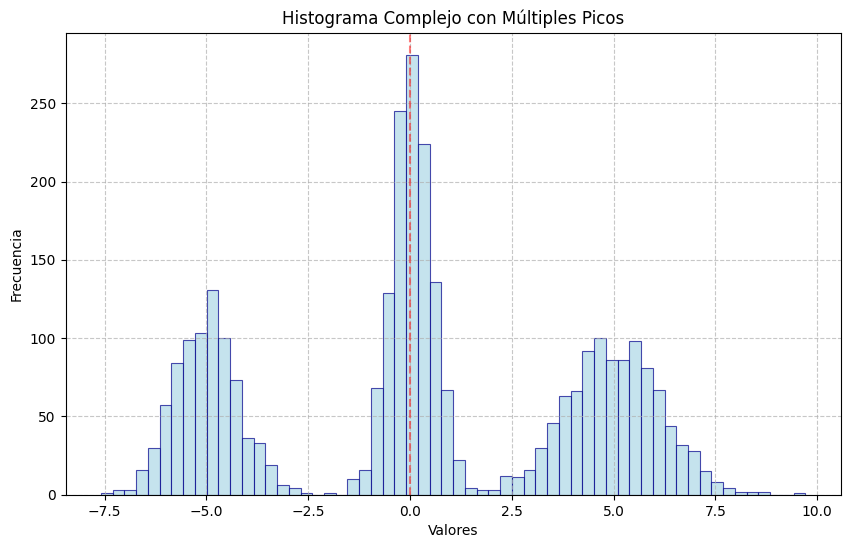

Tipo de gráfico detectado: line


In [5]:
# Crear un ejemplo de histograma más complejo para probar

plt.figure(figsize=(10, 6))

# Generar datos con múltiples picos
np.random.seed(42)
data1 = np.random.normal(-5, 0.8, 800)  # Primer pico
data2 = np.random.normal(0, 0.5, 1200)  # Segundo pico (más pronunciado)
data3 = np.random.normal(5, 1.2, 1000)  # Tercer pico (más ancho)
complex_data = np.concatenate([data1, data2, data3])

# Crear histograma con opciones personalizadas
hist_complex = plt.hist(complex_data, bins=60, 
                        color='lightblue', edgecolor='darkblue', 
                        alpha=0.7, linewidth=0.8)

plt.title('Histograma Complejo con Múltiples Picos')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)  # Línea vertical en x=0

ax_complex = plt.gca()
plt.show()

# Detectar tipo de gráfico
plot_type = detect_plot_type(ax_complex)
print(f"Tipo de gráfico detectado: {plot_type}")

# Extraer datos y crear visualización Vega-Lite
if plot_type == 'histogram':
    data = extract_histogram_data(ax_complex)
    chart = create_vega_lite_histogram(ax_complex, data)
    
    # Agregar una línea vertical en x=0 para el gráfico de Vega-Lite
    vertical_line = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
        color='red', 
        strokeDash=[6, 3], 
        strokeWidth=1.5,
        opacity=0.5
    ).encode(x='x')
    
    # Combinar el histograma con la línea vertical
    final_chart = chart + vertical_line
    
    # Mostrar el resultado
    display(final_chart)

## Conclusiones

Hemos mejorado significativamente el manejo de histogramas en la conversión de Matplotlib a Vega-Lite:

1. **Mejor detección**: Ahora podemos detectar correctamente cuando un gráfico es un histograma mediante múltiples características
2. **Extracción robusta de datos**: Implementamos dos métodos para extraer los datos:
   - Directo desde la tupla que devuelve la función `hist()`
   - Desde los objetos Rectangle de los "patches" del histograma
3. **Visualización mejorada**: La representación en Vega-Lite ahora:
   - Respeta los bordes exactos de los bins
   - Mantiene las proporciones correctas
   - Incluye tooltips informativos
   - Permite añadir elementos adicionales como líneas de referencia

Este enfoque es mucho más robusto y produce visualizaciones de histograma de mayor calidad al convertir de Matplotlib a Vega-Lite.